In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import collresolve
import math
rebound.__version__

'3.18.1'

In [2]:
g_to_sol = 5.02785431e-34
cm_to_au = 6.68458712226845e-14
g_cm3_to_sol_au3 = g_to_sol/cm_to_au**3
day_to_yr = 1/365.25
MAX_TIME = 5000/day_to_yr

In [3]:
g_cm3_to_sol_au3

1683289.913060393

In [4]:
def setup_sim(big_in_raw):

    sim = rebound.Simulation()
    sim.units = ('day', 'AU', 'Msun') # or whatever units you want
    sim.integrator = "ias15"
    sim.dt = 6 # or whatever stepsize you want (IAS15 is adaptive anyway so it will adjust)
    sim.add(m=1, r=0.2) # Sun added at center of system with collisional radius of .2 AU
    ps = sim.particles
    for i, line in enumerate(big_in_raw):
        if line[0] == ')':
            continue
        if i%4 == 0:
            id, m, d = line.split(' ')[-3:]
            id = int(id)
            m = float(m.split('=')[-1])
            d = float(d.split('=')[-1]) * g_cm3_to_sol_au3
            r = (m/d/(4/3*np.pi))**(1/3)
            # print(r, r/m_to_au*1e-3)
        if i%4 == 1:
            x,y,z = np.array(line.split(' ')).astype(float)
        if i%4 == 2:
            vx,vy,vz = np.array(line.split(' ')).astype(float)
        if i%4 == 3:
            sim.add(m=m,r=r,x=x,y=y,z=z,vx=vx,vy=vy,vz=vz,hash=id)
    return sim, ps

In [27]:
for i in [1,2,3,4,11,12,13,14,21,22,23,24,31,32,33,34]:
    with open('../inputs/init_conds/sim_{:02.0f}_frag/big.in'.format(i), 'r') as f:
        big_in_raw = f.readlines()
    big_in_raw = big_in_raw[6:]
    sim, ps = setup_sim(big_in_raw)
    sim.save("../inputs/sim_inits/sim_{:02.0f}_frag.bin".format(i))

    with open('../inputs/init_conds/sim_{:02.0f}_merg/big.in'.format(i), 'r') as f:
        big_in_raw = f.readlines()
    big_in_raw = big_in_raw[6:]
    sim, ps = setup_sim(big_in_raw)
    sim.save("../inputs/sim_inits/sim_{:02.0f}_merg.bin".format(i))

In [29]:
sim = rebound.Simulation("../inputs/sim_inits/sim_31_merg.bin")
sim.N

160

In [16]:
sim.automateSimulationArchive('test_sa.bin', step=10)
sim.integrate(600)

/Users/rmelikyan/Projects/collresolve/.venv/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: File in use for SimulationArchive already exists. Snapshots will be appended.
  warnings.warn(msg[1:], RuntimeWarning)


In [19]:
sa = rebound.SimulationArchive('test_sa.bin')
len(sa)
for i in range(len(sa)-1):
    sim = sa[i]
    print(sim.t)

0.0
60.0
120.0
180.0
240.0
300.0
360.0
420.0
480.0
540.0


In [26]:
def p2b(p):
    """Converts Rebound Particle into Collresolve Body"""
    return collresolve.Body(p.m, p.r, p.x, p.y, p.z, p.vx, p.vy, p.vz)

def b2p(b):
    """Converts Collresolve Body into Rebound Particle"""
    m = b.mass
    r = b.radius
    x = b.pos_x
    y = b.pos_y
    z = b.pos_z
    vx = b.vel_x
    vy = b.vel_y
    vz = b.vel_z
    return rebound.particle.Particle(m=m, x=x, y=y, z=z, vx=vx, vy=vy, vz=vz, r=r)

def coll_resolve_merge(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    swap = False
    if ps[i].m < ps[j].m:
        i = collided_particles_index.p2
        j = collided_particles_index.p1
        swap = True

    big = p2b(ps[i])
    small = p2b(ps[j])
    conf = collresolve.Conf()
    collresolve.conf_unit_merc(conf)
    model = collresolve.MODEL_PERFECT_MERGE
    # model = collresolve.MODEL_C2019
    collresolve.conf_model(conf, model)
    # imp_vel = collresolve.impact_velocity(conf, big, small)
    # imp_ang = collresolve.impact_angle(conf, big, small)
    # collresolve.setup(conf, big, small, imp_vel, imp_ang)
    print( "collision time = {0:.1f} years".format(sim.t*day_to_yr))
    print( "impact velocity = {0:.1f} AU/day".format( collresolve.impact_velocity( conf, big, small ) ) )
    print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
    print( "impact angle = {0:.1f} deg".format( math.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )

    print(res)

    ps[i] = b2p(res[0])
    ps[j] = b2p(res[1])

    return 0 if ps[j].m > 0 else (1 if swap else 2)

def coll_resolve_C2019(sim_pointer, collided_particles_index):

    sim = sim_pointer.contents # retreive the standard simulation object
    ps = sim.particles # easy access to list of particles

    i = collided_particles_index.p1   # Note that p1 < p2 is not guaranteed.    
    j = collided_particles_index.p2 

    swap = False
    if ps[i].m < ps[j].m:
        i = collided_particles_index.p2
        j = collided_particles_index.p1
        swap = True

    big = p2b(ps[i])
    small = p2b(ps[j])
    conf = collresolve.Conf()
    collresolve.conf_unit_merc(conf)
    # model = collresolve.MODEL_PERFECT_MERGE # Can use this for merger model instead
    model = collresolve.MODEL_C2019
    collresolve.conf_model(conf, model)
    print( "collision time = {0:.1f} years".format(sim.t*day_to_yr))
    print( "impact velocity = {0:.1e} AU/day".format( collresolve.impact_velocity( conf, big, small ) ) )
    print( "velocity ratio = {0:.2f}".format( collresolve.impact_velocity( conf, big, small ) / collresolve.escape_velocity( conf, big, small ) ) )
    print( "impact angle = {0:.1f} deg".format( math.degrees( collresolve.impact_angle( conf, big, small ) ) ) )
    res, regime = collresolve.resolve( conf, big, small, 2, 1 )

    print(res)

    ps[i] = b2p(res[0])
    ps[j] = b2p(res[1])

    return 0 if ps[j].m > 0 else (1 if swap else 2)

In [30]:
sim, ps = setup_sim()
sim.collision = "direct"
# sim.collision_resolve = "merge" # Built in function
sim.collision_resolve = coll_resolve_merge # collresolve merge
sim.collision_resolve = coll_resolve_C2019 # collresolve hit and run

print("Particles in the simulation at t=%6.1f: %d"%(sim.t*day_to_yr,sim.N))
# print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(MAX_TIME)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t*day_to_yr,sim.N))
# print("System Mass: {}".format([p.m for p in sim.particles]))

Particles in the simulation at t=   0.0: 156
collision time = 44.3 years
impact velocity = 1.5e-03 AU/day
velocity ratio = 1.00
impact angle = 60.6 deg
[collresolve.Body(mass=1.002868e-07, radius=1.6228732155206607e-05, pos_x=1.1481619305082122, pos_y=0.2008318605894613, pos_z=-0.002307873006540308, vel_x=-0.003708920654114641, vel_y=0.014906593154559174, vel_z=1.7653429154281843e-06), collresolve.Body(mass=0.0, radius=0.0, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0), collresolve.Body(mass=0.0, radius=0.0, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0)]
collision time = 456.1 years
impact velocity = 1.5e-03 AU/day
velocity ratio = 1.00
impact angle = 27.0 deg
[collresolve.Body(mass=1.0006940801422972e-07, radius=1.6217477301900336e-05, pos_x=-2.080972102591589, pos_y=-1.042920830992096, pos_z=-0.011539053145872242, vel_x=0.00011691480653142213, vel_y=-0.014620984970667193, vel_z=9.253801742992166e-05), collresolve.Body(mass=0.0, radius=0.0, pos_

In [28]:
sim.t

46780.737547418714

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

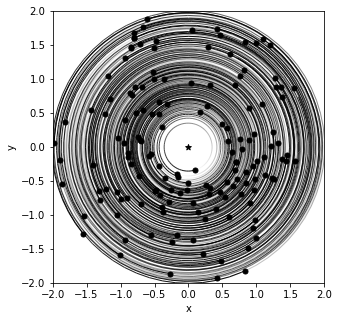

In [29]:
sim.move_to_com()
xlim=(-2,2)
ylim=(-2,2)
rebound.OrbitPlot(sim, xlim=xlim, ylim=ylim)

In [29]:
# sim, ps = setup_sim()
# sim.collision = "direct"
# sim.collision_resolve = coll_resolve_C2019 # Built in function

print("Particles in the simulation at t=%6.1f: %d"%(sim.t*day_to_yr,sim.N))
# print("System Mass: {}".format([p.m for p in sim.particles]))
sim.integrate(MAX_TIME)
print("Particles in the simulation at t=%6.1f: %d"%(sim.t*day_to_yr,sim.N))
# print("System Mass: {}".format([p.m for p in sim.particles]))

Particles in the simulation at t=830924.5: 71
collision time = 851660.7 years
impact velocity = 2.7e-03 AU/day
velocity ratio = 1.11
impact angle = 61.0 deg
[collresolve.Body(mass=3.3872555587063185e-07, radius=2.368659180359594e-05, pos_x=0.6955266850934912, pos_y=0.8526292826130291, pos_z=-0.012885765418025606, vel_x=-0.0124093085943393, vel_y=0.010081492494913163, vel_z=0.0005151744304112314), collresolve.Body(mass=3.1210088895073765e-08, radius=1.114656155124032e-05, pos_x=0.6955593917838523, pos_y=0.8526185564680827, pos_z=-0.012893042718292275, vel_x=-0.011742566319714693, vel_y=0.007942706378576686, vel_z=0.0016726568370414219), collresolve.Body(mass=0.0, radius=0.0, pos_x=0.0, pos_y=0.0, pos_z=0.0, vel_x=0.0, vel_y=0.0, vel_z=0.0)]
collision time = 851660.7 years
impact velocity = 2.5e-03 AU/day
velocity ratio = 1.01
impact angle = 66.5 deg
[collresolve.Body(mass=3.631763820508965e-07, radius=2.4172881924600164e-05, pos_x=0.6955294444348201, pos_y=0.8526283776882346, pos_z=-0.0

(<Figure size 360x360 with 1 Axes>, <AxesSubplot:xlabel='x', ylabel='y'>)

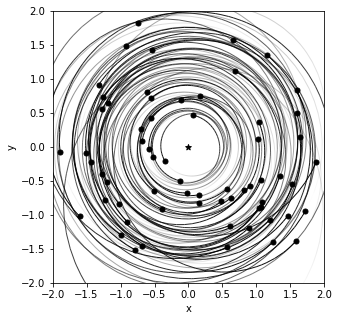

In [30]:
sim.move_to_com()
xlim=(-2,2)
ylim=(-2,2)
rebound.OrbitPlot(sim, xlim=xlim, ylim=ylim)

In [44]:
max([p.m for p in ps[1:-2]])/3e-6

0.12105879401696551

In [47]:
5.01434e-8*153/3e-6

2.5573134000000004